In [1]:
import pandas as pd
import matplotlib.pyplot as plt
# from scipy.interpolate import interp1d
import numpy as np
import pandas as pd
import os
import dask.dataframe as ddf
import re

import sys
sys.path.append("..")

from channeling_lib import AWS_file_loader, load_path, filter_data_based_on_time

stations_str = ['Tom Joad','Rosanna','Bette Davis', 'Layla', 'Mrs Robinson']

# TinyTag_str = ['CEB_1', 'CEB_2', 'CEB_3', 'CEB_4', 'CEB_5', 'TH1', 'TH2', 'TH3', 'TH5', 'TH6', 'TH8', 'TT1', 'TT2', 'TT3', 'TT4', 'TT5', 'TT6', 'TT7', 'TT9', 'TT12', 'TT13', 'TT14', 'TT15', 'TT16', 'TT17', 'TT18']

In [2]:
path = load_path()+'RawData/TinyTag/'

instrument_textbook_name = load_path()+'instrument_textbook_BLcourse_spring2025(BL instruments).csv'
instrument_textbook_data = pd.read_csv(instrument_textbook_name, encoding='latin1')

# instrument_textbook_data['Station name']

# Formatting instrument textbook

This section of the code ensures consistency no matter what chnages in the excel file in sharepoint

In [3]:
# Extract station names (keep only prefix + number)
instrument_textbook_data['Formatted Name'] = [
    re.sub(r"(TT|TH|CEB)(\d+).*", r"\1\2", name) if re.match(r"(TT|TH|CEB)\d+", name) else name
    for name in instrument_textbook_data['Station name']
]

# Find duplicate names
duplicates = instrument_textbook_data['Formatted Name'].value_counts()
duplicate_names = duplicates[duplicates > 1].index  # Names that appear more than once

# Apply "_low" and "_high" based on "Th height (m)"
for name in duplicate_names:
    subset = instrument_textbook_data[instrument_textbook_data['Formatted Name'] == name]
    
    # Find the lowest and highest Th height
    min_index = subset['Thermometer height (m)'].idxmin()
    max_index = subset['Thermometer height (m)'].idxmax()
    
    # Rename them
    instrument_textbook_data.loc[min_index, 'Formatted Name'] = f"{name}_low"
    instrument_textbook_data.loc[max_index, 'Formatted Name'] = f"{name}_high"

# Get final formatted list
formatted_names = instrument_textbook_data['Formatted Name'].tolist()

# formatted_names

The following cell can ONLY be run once. If the following line soudl be 're-run', restart the kernal and run all

In [4]:
# Insert 'Formatted Name' as the first column
instrument_textbook_data.insert(0, 'Formatted Station Name', instrument_textbook_data.pop('Formatted Name'))

# Loading start and end times of Tinytag for calibration

In [5]:
# TinyTag_str = instrument_textbook_data['Station name'].tolist()
TinyTag_str = [s for s in formatted_names if s.startswith(("TT", "TH", "CEB"))]

In [6]:
manual_times = {}

for station in TinyTag_str:
    setup_time_idx = pd.to_datetime(instrument_textbook_data.loc[instrument_textbook_data['Formatted Station Name'] == station, 'Setup time (UTC)'].values[0])

    maintenance_start_time_idx = pd.to_datetime(instrument_textbook_data.loc[instrument_textbook_data['Formatted Station Name'] == station, 'Maintenance start time (UTC)'].values[0])

    # maintenance_duration_idx = int(instrument_textbook_data.loc[instrument_textbook_data['Formatted Station Name'] == station, 'Maintenance duration (minutes)'].values[0])
    maintenance_duration_value = instrument_textbook_data.loc[instrument_textbook_data['Formatted Station Name'] == station, 'Maintenance duration (minutes)'].values[0]
    maintenance_duration_idx = int(maintenance_duration_value) if not pd.isna(maintenance_duration_value) else 0

    retrieval_time_idx = pd.to_datetime(instrument_textbook_data.loc[instrument_textbook_data['Formatted Station Name'] == station, 'Retrieval time (UTC)'].values[0])

    manual_times[station] = {
            'setup_time': setup_time_idx,
            'maintenance_start_time': maintenance_start_time_idx,
            'maintenance_duration': maintenance_duration_idx,
            'retrieval_time': retrieval_time_idx
        }

# manual_times

# Loading TinyTag  data

The TinyTag data is loaded using UNISasci function read_Tinytag(). The data is then loaded dynamically using load_TinyTag_folders() function (Alberte)

- Calibration data
    - ceb_calibration_data = load_TinyTag_folders(path, 'CEB', 'calibration')
    - TH_calibration_data = load_TinyTag_folders(path, 'TH', 'calibration')
    - TT_calibration_data = load_TinyTag_folders(path, 'TT', 'calibration')

- Actual data
    - ceb_data = load_TinyTag_folders(path, 'CEB', 'normal')
    - TH_data = load_TinyTag_folders(path, 'TH', 'normal')
    - TT_data = load_TinyTag_folders(path, 'TT', 'normal')


Specific data is selected by:
- tag_data['tag_i_normal_data']
- tag_calibration_data['tag_i_calibration_data']

Where i corresponds to the TinyTag number in teh raw data folder



In [7]:
#function from unis github
def read_Tinytag(filename, sensor):
    '''
    Reads data from one or several data files from the Tinytag output files.

    Parameters:
    -------
    filename: str
        String with path to file(s)
        If several files shall be read, specify a string including UNIX-style wildcards
    sensor: str
        One of "TT", "TH" or "CEB"
    Returns
    -------
    df : pandas dataframe
        a pandas dataframe with time as index and the individual variables as columns.
    '''

    import dask.dataframe as ddf


    if sensor == "TT":
        df = ddf.read_csv(filename, delimiter="\t", skiprows=5, parse_dates=[1], date_format="%d %b %Y %H:%M:%S", names=["RECORD", "TIMESTAMP", "T_black", "T_white"], encoding = "ISO-8859-1")
    elif sensor == "TH":
        df = ddf.read_csv(filename, delimiter="\t", skiprows=5, parse_dates=[1], date_format="%d %b %Y %H:%M:%S", names=["RECORD", "TIMESTAMP", "T", "RH"], encoding = "ISO-8859-1")
    elif sensor == "CEB":
        df = ddf.read_csv(filename, delimiter="\t", skiprows=5, parse_dates=[1], date_format="%d %b %Y %H:%M:%S", names=["RECORD", "TIMESTAMP", "T"], encoding = "ISO-8859-1")
    else:
        assert False, 'Sensortype of Tinytag not known. Should be one of "TT", "TH" or "CEB".'

    df = df.compute()
    df.set_index("TIMESTAMP", inplace=True)

    for key in list(df.columns):
        if key == "RECORD":
            pass
        else:
            data = [float(i.split(" ")[0]) for i in df[key]]
            unit = df[key].iloc[0].split(" ")[1]
            if unit == "°C":
                unit = "degC"
            new_key = f"{key}_{unit}"

            df[new_key] = data

            df.drop(key, axis=1, inplace=True)

    return df

In [8]:
# old function
# def load_TinyTag_folders(path, tag, datatype):
#     """
#     Processes folders that start with a specific prefix, reads corresponding files,
#     and stores their datasets in a dictionary.
#     """
#     # prefix = 0
#     # prefix = []
#     if tag == 'CEB':
#         prefix = 'CEB_'
#     elif tag == 'TH':
#         prefix = 'TH'
#     elif tag == 'TT':
#         prefix = 'TT'

#     if datatype == 'calibration':
#         folders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f)) and f.startswith(prefix)]
#         calibration_data = {}

#         for folder in folders:
#             folder_path = os.path.join(path, folder)
#             files = [f for f in os.listdir(folder_path) if f.startswith(f"{folder}_calibration_") and f.endswith(".txt")]
            
#             for file in files:
#                 file_path = os.path.join(folder_path, file)
#                 dataset = read_Tinytag(file_path, tag)  # Process the file
#                 calibration_data[f"{folder}_calibration_data"] = dataset
        
#         return calibration_data
    
#     elif datatype == 'normal':
#         folders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f)) and f.startswith(prefix)]
#         normal_data = {}

#         for folder in folders:
#             folder_path = os.path.join(path, folder)
#             # Filter files that DO NOT contain "_calibration" in their name
#             files = [f for f in os.listdir(folder_path) if "_calibration" not in f and f.endswith(".txt")]
            
#             for file in files:
#                 file_path = os.path.join(folder_path, file)
#                 dataset = read_Tinytag(file_path, tag)  # Process the file
#                 normal_data[f"{folder}_normal_data"] = dataset  # Different key to distinguish

#         return normal_data

In [9]:
# new function that if there is more tahn one data file in folder for 'normal' data, combines them

def load_TinyTag_folders(path, tag, datatype):
    """
    Processes folders that start with a specific prefix, reads corresponding files,
    and stores their datasets in a dictionary. If multiple normal datasets exist,
    they are merged into a single DataFrame while keeping the same format.
    """
    # prefix = 0
    # prefix = []
    if tag == 'CEB':
        prefix = 'CEB_'
    elif tag == 'TH':
        prefix = 'TH'
    elif tag == 'TT':
        prefix = 'TT'

    folders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f)) and f.startswith(prefix)]

    if datatype == 'calibration':
        calibration_data = {}
        for folder in folders:
            folder_path = os.path.join(path, folder)
            files = [f for f in os.listdir(folder_path) if f.startswith(f"{folder}_calibration_") and f.endswith(".txt")]

            for file in files:
                file_path = os.path.join(folder_path, file)
                dataset = read_Tinytag(file_path, tag)  # Process the file
                
                if f"{folder}_calibration_data" in calibration_data:
                    # Concatenating multiple calibration datasets while preserving timestamp index
                    calibration_data[f"{folder}_calibration_data"] = pd.concat(
                        [calibration_data[f"{folder}_calibration_data"], dataset]
                    ).sort_index()
                else:
                    calibration_data[f"{folder}_calibration_data"] = dataset  # First dataset

        return calibration_data

    elif datatype == 'normal':
        normal_data = {}
        for folder in folders:
            folder_path = os.path.join(path, folder)
            files = [f for f in os.listdir(folder_path) if "_calibration" not in f and f.endswith(".txt")]

            for file in files:
                file_path = os.path.join(folder_path, file)
                dataset = read_Tinytag(file_path, tag)  # Process the file
                
                # Ensure the index remains as timestamp if available
                if isinstance(dataset.index, pd.DatetimeIndex):
                    dataset = dataset.sort_index()  # Ensure sorted order
                
                # Merge DataFrames properly
                if f"{folder}_normal_data" in normal_data:
                    normal_data[f"{folder}_normal_data"] = pd.concat(
                        [normal_data[f"{folder}_normal_data"], dataset]
                    ).sort_index()
                else:
                    normal_data[f"{folder}_normal_data"] = dataset  # First dataset

        return normal_data


In [10]:
ceb_calibration_data = load_TinyTag_folders(path, 'CEB', 'calibration')
TH_calibration_data = load_TinyTag_folders(path, 'TH', 'calibration')
TT_calibration_data = load_TinyTag_folders(path, 'TT', 'calibration')

ceb_data = load_TinyTag_folders(path, 'CEB', 'normal')
TH_data = load_TinyTag_folders(path, 'TH', 'normal')
TT_data = load_TinyTag_folders(path, 'TT', 'normal')

In [11]:
TH_data['TH2_normal_data'].shape

(17676, 3)

In [12]:
# Loop through each DataFrame inside the dictionary
for key in TH_calibration_data.keys():
    df = TH_calibration_data[key]
    
    # Rename column if it exists
    if "RH_%RH" in df.columns:
        df = df.rename(columns={"RH_%RH": "RH"})
        TH_calibration_data[key] = df  # Update the dataset


for key in TH_data.keys():
    df = TH_data[key]
    
    # Rename column if it exists
    if "RH_%RH" in df.columns:
        df = df.rename(columns={"RH_%RH": "RH"})
        TH_data[key] = df  # Update the dataset
        

In [13]:
# [tag for tag in TinyTag_str if tag.startswith("TT")]

Formatting the data to remove the seconds - yielding format yyyy-mm-dd h:m

In [14]:
datasets = [ceb_calibration_data, TH_calibration_data, TT_calibration_data,
            ceb_data, TH_data, TT_data]

# Loop through each dataset
for dataset in datasets:
    for key in dataset.keys():  # Iterate over each DataFrame inside the dictionary
        dataset[key].index = dataset[key].index.round('min')
        # dataset[key].index = pd.to_datetime(dataset[key].index.strftime('%Y-%m-%d %H:%M'))


# Filtering data based on setup and retrival times

Filter calibration data based on manual inspection of plotted data

# Filter CEB

In [15]:
calibration_filter_start_date = pd.Timestamp('2025-01-24 11:00:00')
calibration_filter_end_date = pd.Timestamp('2025-01-25 14:00:00')

Plot raw CEB claibration data

In [16]:
# fig, ax = plt.subplots(nrows=5, sharex=True, figsize=(12, 15))  

# # List of dataset keys for iteration
# dataset_keys = [f"CEB_{i}_calibration_data" for i in range(1, 6)]

# # Loop through each subplot and dataset
# for i, key in enumerate(dataset_keys):
#     ax[i].plot(ceb_calibration_data[key].index, 
#                ceb_calibration_data[key].T_degC, label=key.replace("_calibration_data", ""))
#     ax[i].set_title(f"{key.replace('_calibration_data', '')} Calibration")

#     # Add vertical lines
#     ax[i].axvline(x=calibration_filter_start_date, color='red', linestyle='--')
#     ax[i].axvline(x=calibration_filter_end_date, color='red', linestyle='--')

#     ax[i].grid(True)  # Enable grid
#     # ax[i].legend()  # Add legend

# # Set x-axis label only on the last subplot
# ax[-1].set_xlabel("Time")

# plt.show()


Remove CEB data beofore and after red lines

In [17]:
# Loop through each DataFrame inside the dictionary and apply the filter
for key in ceb_calibration_data.keys():
    df = ceb_calibration_data[key]
    
    # Apply filter: Keep only rows within the start and end date range
    filtered_df = df[(df.index >= calibration_filter_start_date) & (df.index <= calibration_filter_end_date)]
    
    # Update the dataset with the filtered data
    ceb_calibration_data[key] = filtered_df


Plot filtered CEB calibration data

In [18]:
# fig, ax = plt.subplots(nrows=5, sharex=True, figsize=(12, 15))  

# # List of dataset keys for iteration
# dataset_keys = [f"CEB_{i}_calibration_data" for i in range(1, 6)]

# # Loop through each subplot and dataset
# for i, key in enumerate(dataset_keys):
#     ax[i].plot(ceb_calibration_data[key].index, 
#                ceb_calibration_data[key].T_degC, label=key.replace("_calibration_data", ""))
#     ax[i].set_title(f"{key.replace('_calibration_data', '')} Calibration")

#     # Add vertical lines
#     ax[i].axvline(x=calibration_filter_start_date, color='red', linestyle='--')
#     ax[i].axvline(x=calibration_filter_end_date, color='red', linestyle='--')

#     ax[i].grid(True)  # Enable grid
#     # ax[i].legend()  # Add legend

# # Set x-axis label only on the last subplot
# ax[-1].set_xlabel("Time")

# plt.show()


# Filter TH

Plot raw TH calibration data

In [19]:
# # Get all dataset keys dynamically based on TinyTag_str
# dataset_keys = [f"{tag}_calibration_data" for tag in TinyTag_str if tag.startswith("TH") and f"{tag}_calibration_data" in TH_calibration_data]

# # Adjust nrows based on the actual number of TH datasets
# fig, ax = plt.subplots(nrows=len(dataset_keys), sharex=True, figsize=(12, 3 * len(dataset_keys)))

# # Ensure ax is always iterable (for single subplot cases)
# if len(dataset_keys) == 1:
#     ax = [ax]

# # Loop through each subplot and dataset
# for i, key in enumerate(dataset_keys):
#     ax[i].plot(TH_calibration_data[key].index, 
#                TH_calibration_data[key].T_degC, label=key.replace("_calibration_data", ""))
#     ax[i].set_title(f"{key.replace('_calibration_data', '')} Calibration")

#     # Add vertical lines
#     ax[i].axvline(x=calibration_filter_start_date, color='red', linestyle='--')
#     ax[i].axvline(x=calibration_filter_end_date, color='red', linestyle='--')

#     ax[i].grid(True)  # Enable grid

# # Set x-axis label only on the last subplot
# ax[-1].set_xlabel("Time")


Remove TH data beofore and after red lines

In [20]:
# Loop through each DataFrame inside the dictionary and apply the filter
for key in TH_calibration_data.keys():
    df = TH_calibration_data[key]
    
    # Apply filter: Keep only rows within the start and end date range
    filtered_df = df[(df.index >= calibration_filter_start_date) & (df.index <= calibration_filter_end_date)]
    
    # Update the dataset with the filtered data
    TH_calibration_data[key] = filtered_df


Plot filtered TH calibration data

In [21]:
# # Get all dataset keys dynamically based on TinyTag_str
# dataset_keys = [f"{tag}_calibration_data" for tag in TinyTag_str if tag.startswith("TH") and f"{tag}_calibration_data" in TH_calibration_data]

# # Adjust nrows based on the actual number of TH datasets
# fig, ax = plt.subplots(nrows=len(dataset_keys), sharex=True, figsize=(12, 3 * len(dataset_keys)))

# # Ensure ax is always iterable (for single subplot cases)
# if len(dataset_keys) == 1:
#     ax = [ax]

# # Loop through each subplot and dataset
# for i, key in enumerate(dataset_keys):
#     ax[i].plot(TH_calibration_data[key].index, 
#                TH_calibration_data[key].T_degC, label=key.replace("_calibration_data", ""))
#     ax[i].set_title(f"{key.replace('_calibration_data', '')} Calibration")

#     # Add vertical lines
#     ax[i].axvline(x=calibration_filter_start_date, color='red', linestyle='--')
#     ax[i].axvline(x=calibration_filter_end_date, color='red', linestyle='--')

#     ax[i].grid(True)  # Enable grid

# # Set x-axis label only on the last subplot
# ax[-1].set_xlabel("Time")


In [22]:
# TH_calibration_data['TH1_calibration_data']

# Filter TT

Plot raw TT calibration data

In [23]:
# # Get all dataset keys dynamically based on TinyTag_str
# dataset_keys = sorted({f"{tag.split('_')[0]}_calibration_data" for tag in TinyTag_str 
#                        if tag.startswith("TT") and tag.endswith(("_low", "_high")) and f"{tag.split('_')[0]}_calibration_data" in TT_calibration_data})


# # Adjust nrows based on the actual number of TH datasets
# fig, ax = plt.subplots(nrows=len(dataset_keys), sharex=True, figsize=(12, 3 * len(dataset_keys)))

# # Ensure ax is always iterable (for single subplot cases)
# if len(dataset_keys) == 1:
#     ax = [ax]

# # Loop through each subplot and dataset
# for i, key in enumerate(dataset_keys):
#     ax[i].plot(TT_calibration_data[key].index, 
#                TT_calibration_data[key].T_black_degC, label=f'{key} black'.replace("_calibration_data", ""))
#     ax[i].plot(TT_calibration_data[key].index, 
#                TT_calibration_data[key].T_white_degC, label=f'{key} white'.replace("_calibration_data", ""))
    
#     ax[i].set_title(f"{key.replace('_calibration_data', '')} Calibration")

#     # Add vertical lines
#     ax[i].axvline(x=calibration_filter_start_date, color='red', linestyle='--')
#     ax[i].axvline(x=calibration_filter_end_date, color='red', linestyle='--')

#     ax[i].grid(True)  # Enable grid
#     ax[i].legend()

# # Set x-axis label only on the last subplot
# ax[-1].set_xlabel("Time")


Remove TT data beofore and after red lines

In [24]:
# Loop through each DataFrame inside the dictionary and apply the filter
for key in TT_calibration_data.keys():
    df = TT_calibration_data[key]
    
    # Apply filter: Keep only rows within the start and end date range
    filtered_df = df[(df.index >= calibration_filter_start_date) & (df.index <= calibration_filter_end_date)]
    
    # Update the dataset with the filtered data
    TT_calibration_data[key] = filtered_df

Plot filtered TT calibration data

In [25]:
# # Get all dataset keys dynamically based on TinyTag_str
# dataset_keys = sorted({f"{tag.split('_')[0]}_calibration_data" for tag in TinyTag_str 
#                        if tag.startswith("TT") and tag.endswith(("_low", "_high")) and f"{tag.split('_')[0]}_calibration_data" in TT_calibration_data})


# # Adjust nrows based on the actual number of TH datasets
# fig, ax = plt.subplots(nrows=len(dataset_keys), sharex=True, figsize=(12, 3 * len(dataset_keys)))

# # Ensure ax is always iterable (for single subplot cases)
# if len(dataset_keys) == 1:
#     ax = [ax]

# # Loop through each subplot and dataset
# for i, key in enumerate(dataset_keys):
#     ax[i].plot(TT_calibration_data[key].index, 
#                TT_calibration_data[key].T_black_degC, label=f'{key} black'.replace("_calibration_data", ""))
#     ax[i].plot(TT_calibration_data[key].index, 
#                TT_calibration_data[key].T_white_degC, label=f'{key} white'.replace("_calibration_data", ""))
#     ax[i].set_title(f"{key.replace('_calibration_data', '')} Calibration")

#     # Add vertical lines
#     ax[i].axvline(x=calibration_filter_start_date, color='red', linestyle='--')
#     ax[i].axvline(x=calibration_filter_end_date, color='red', linestyle='--')

#     ax[i].grid(True)  # Enable grid

# # Set x-axis label only on the last subplot
# ax[-1].set_xlabel("Time")


# Filter normal TinyTag data

Altering code used to filter AWS data, to filter tinytag data

In [26]:
# TT_data['TT12_normal_data']
# TH_data['TH1_normal_data']
# ceb_data['CEB_1_normal_data']

# manual_times['TT12_high']
# manual_times['TH1']
# manual_times['CEB3']


In [27]:
def filter_data_based_on_time_tinytag(data_dict, manual_times, prefix):
    """
    Filters TinyTag datasets by removing:
      - Data before the setup time
      - Data after the retrieval time
      - Data during the maintenance period (if applicable).
    
    If a dataset does NOT have a corresponding entry in `manual_times`, it is EXCLUDED from `filtered_data`.

    Parameters:
        data_dict (dict): Dictionary containing dataset DataFrames.
        manual_times (dict): Dictionary containing setup, maintenance, and retrieval times.
        prefix (str): Prefix for dataset type (e.g., 'TT', 'TH', 'CEB').

    Returns:
        dict: Filtered dataset dictionary (excluding datasets without matching time data).
    """
    filtered_data = {}

    for key, df in data_dict.items():
        # Extract the numeric identifier based on the dataset prefix
        if prefix == "TT":
            match = re.search(r'TT(\d+)', key)  # Extracts the number from "TT12_normal_data"
        elif prefix == "TH":
            match = re.search(r'TH(\d+)', key)  # Extracts the number from "TH1_normal_data"
        elif prefix == "CEB":
            match = re.search(r'CEB_(\d+)', key)  # Extracts the number from "CEB_1_normal_data"
        else:
            match = None

        dataset_id = match.group(1) if match else None

        if dataset_id:
            # Look for a matching key in manual_times (e.g., "TT12_high", "TH1", "CEB3")
            matching_keys = [manual_key for manual_key in manual_times if f"{prefix}{dataset_id}" in manual_key]

            if matching_keys:
                # Assume first found key is the correct match
                manual_key = matching_keys[0]
                times = manual_times[manual_key]

                setup_time = times['setup_time']
                retrieval_time = times['retrieval_time']
                maintenance_start = times['maintenance_start_time']
                maintenance_duration = times['maintenance_duration']

                # Compute maintenance end time if applicable
                maintenance_end = maintenance_start + pd.Timedelta(minutes=maintenance_duration) if pd.notna(maintenance_start) else None

                # Apply setup and retrieval filtering
                df_filtered = df[(df.index >= setup_time) & (df.index <= retrieval_time)]
                
                # Remove data within maintenance period if applicable
                if pd.notna(maintenance_start) and maintenance_end is not None:
                    df_filtered = df_filtered[~((df_filtered.index >= maintenance_start) & (df_filtered.index <= maintenance_end))]

                # Store the filtered DataFrame
                filtered_data[key] = df_filtered

    return filtered_data


In [28]:
# Apply filtering to each dataset type with the correct prefix
TH_data_filtered = filter_data_based_on_time_tinytag(TH_data, manual_times, "TH")
TT_data_filtered = filter_data_based_on_time_tinytag(TT_data, manual_times, "TT")
ceb_data_filtered = filter_data_based_on_time_tinytag(ceb_data, manual_times, "CEB")

In [29]:
for key in TH_data_filtered.keys():
    df = TH_data_filtered[key]
    
    # Rename column if it exists
    if "RH_%RH" in df.columns:
        df = df.rename(columns={"RH_%RH": "RH"})
        TH_data_filtered[key] = df  # Update the dataset

In [30]:
# ceb_data_filtered

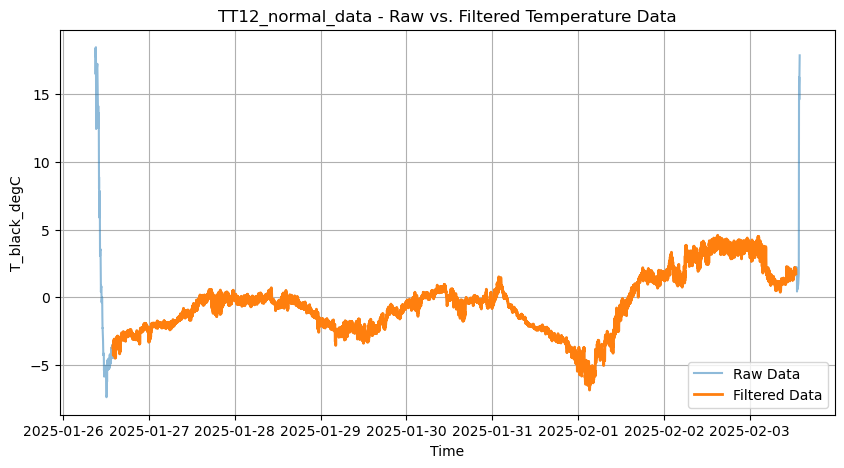

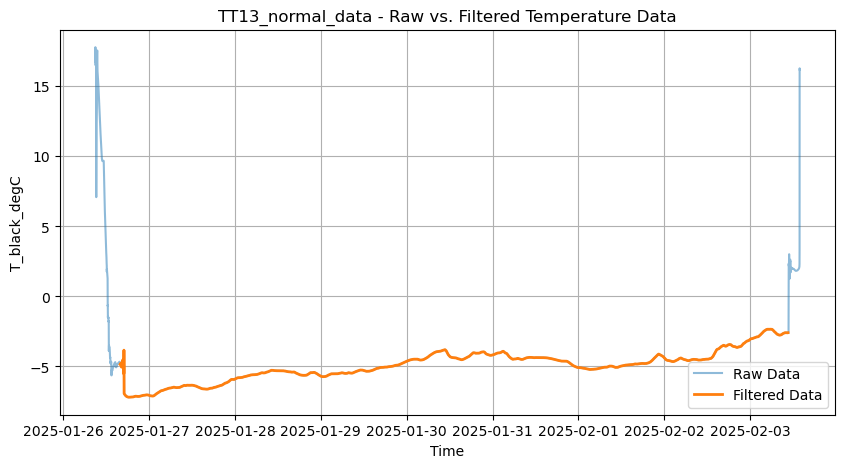

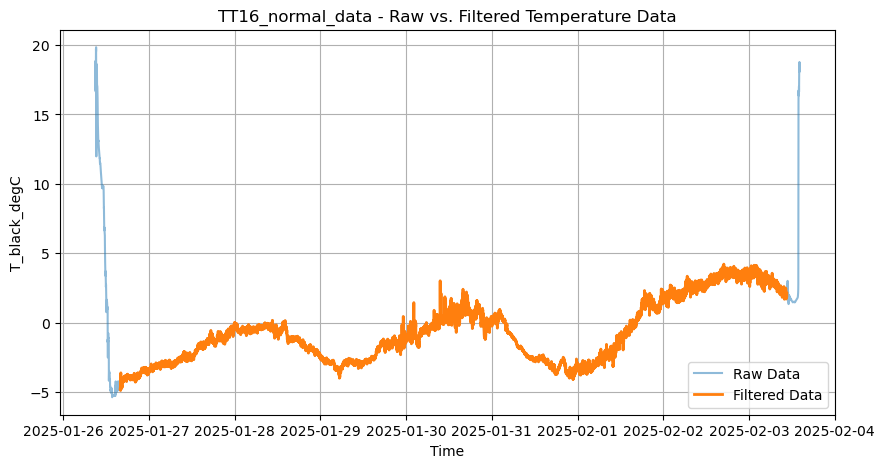

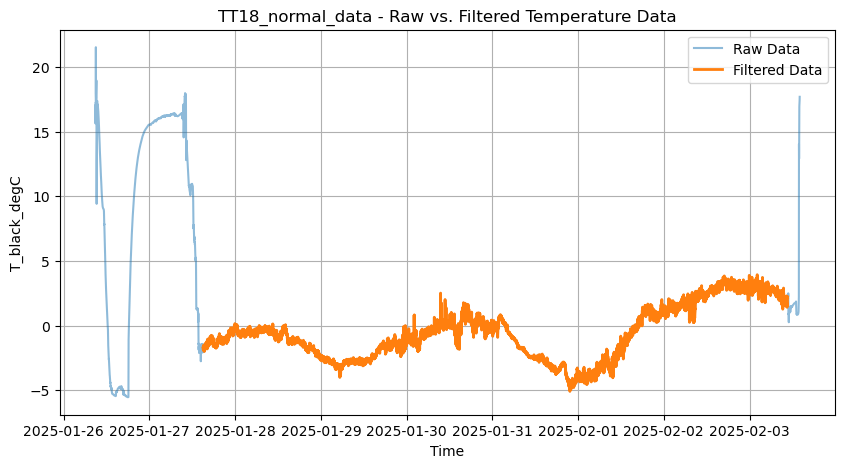

In [31]:
def plot_all_TT_data(TT_data, TT_data_filtered):
    """
    Plots the original and filtered datasets for all TT data.
    
    Parameters:
        TT_data (dict): Dictionary of unfiltered TT datasets.
        TT_data_filtered (dict): Dictionary of filtered TT datasets.
    """
    for key in TT_data:
        if key in TT_data_filtered:  # Only plot if there is a filtered version
            plt.figure(figsize=(10, 5))
            plt.plot(TT_data[key].index, TT_data[key]['T_black_degC'], label='Raw Data', alpha=0.5)
            plt.plot(TT_data_filtered[key].index, TT_data_filtered[key]['T_black_degC'], label='Filtered Data', linewidth=2)
            plt.title(f"{key} - Raw vs. Filtered Temperature Data")
            plt.xlabel("Time")
            plt.ylabel("T_black_degC")
            plt.legend()
            plt.grid(True)
            plt.show()

# Call the function to plot all TT datasets
plot_all_TT_data(TT_data, TT_data_filtered)


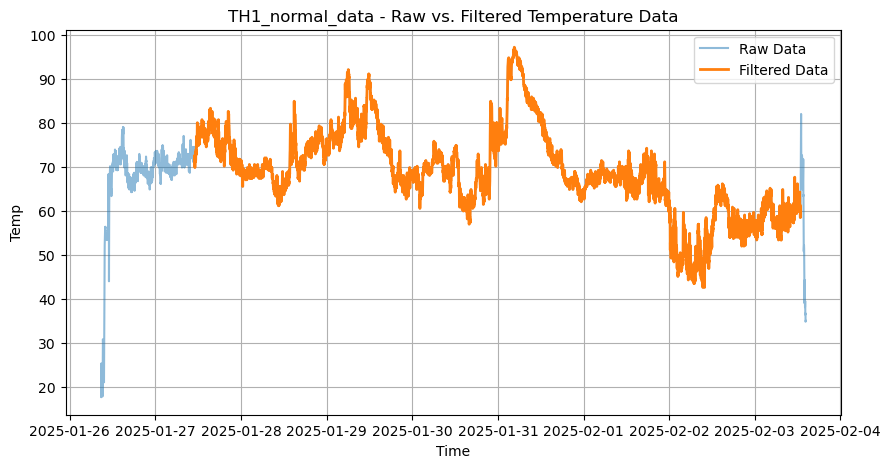

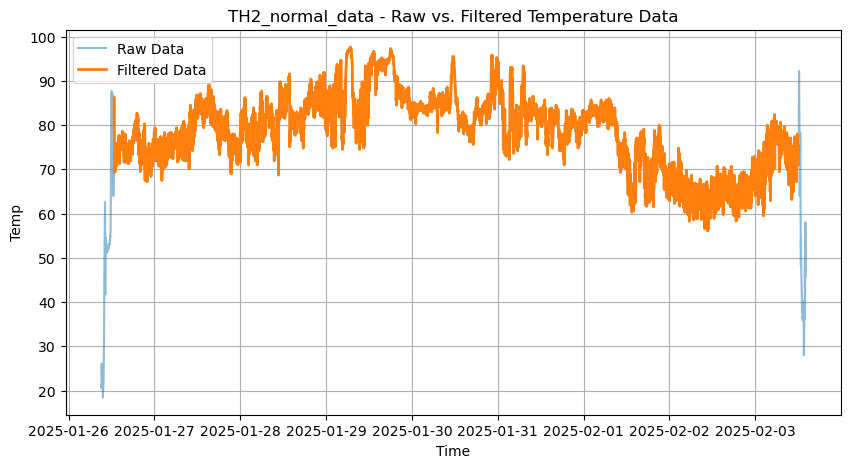

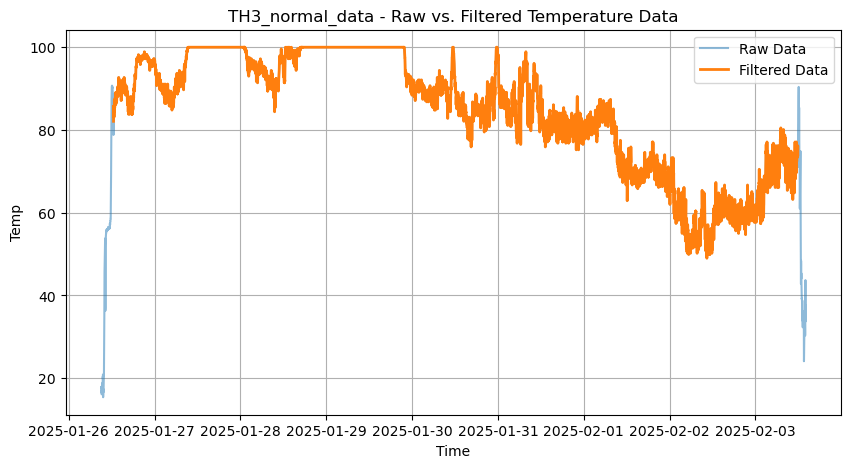

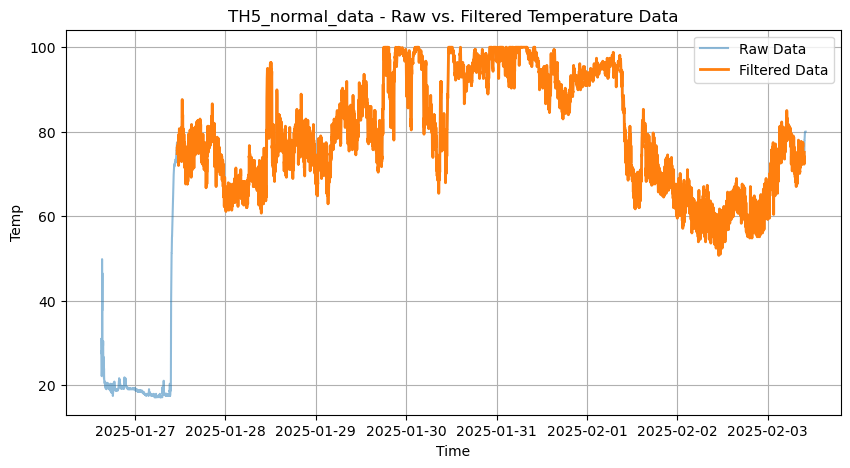

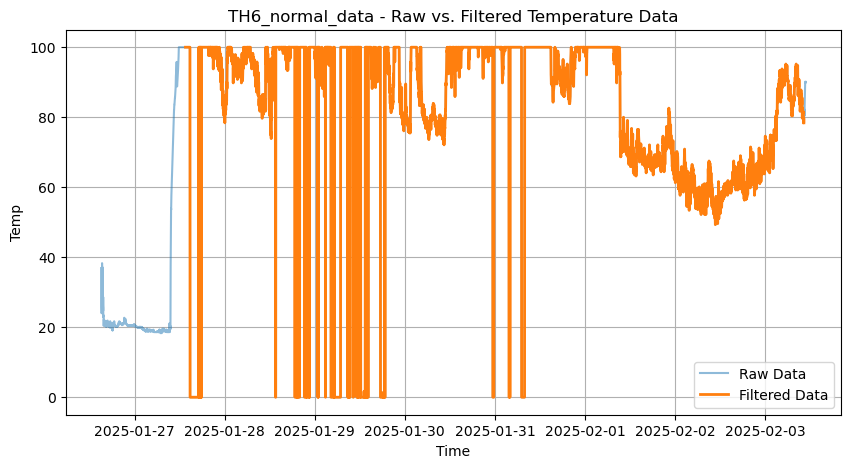

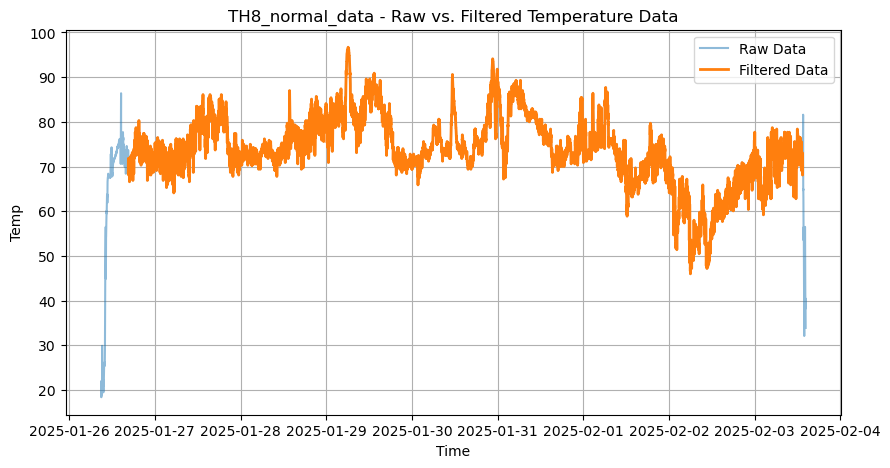

In [32]:
def plot_all_TH_data(TH_data, TH_data_filtered):
  
    for key in TH_data:
        if key in TH_data_filtered:  # Only plot if there is a filtered version
            plt.figure(figsize=(10, 5))
            plt.plot(TH_data[key].index, TH_data[key]['RH'], label='Raw Data', alpha=0.5)
            plt.plot(TH_data_filtered[key].index, TH_data_filtered[key]['RH'], label='Filtered Data', linewidth=2)
            plt.title(f"{key} - Raw vs. Filtered Temperature Data")
            plt.xlabel("Time")
            plt.ylabel("Temp")
            plt.legend()
            plt.grid(True)
            plt.show()

# Call the function to plot all TT datasets
plot_all_TH_data(TH_data, TH_data_filtered)

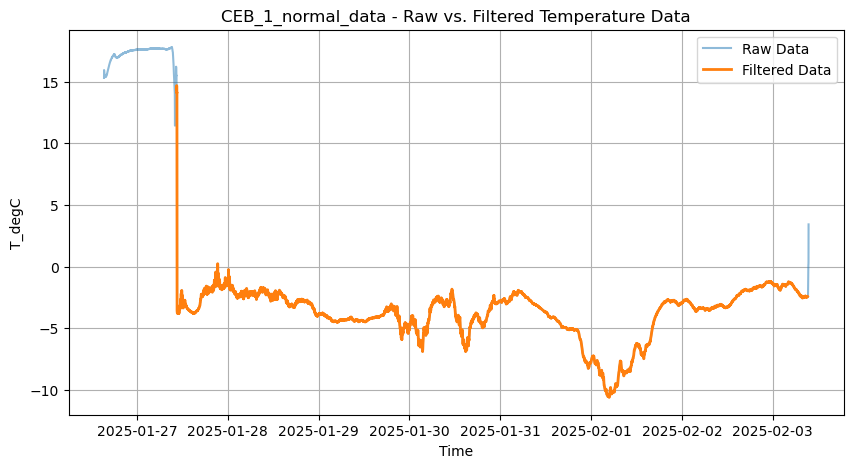

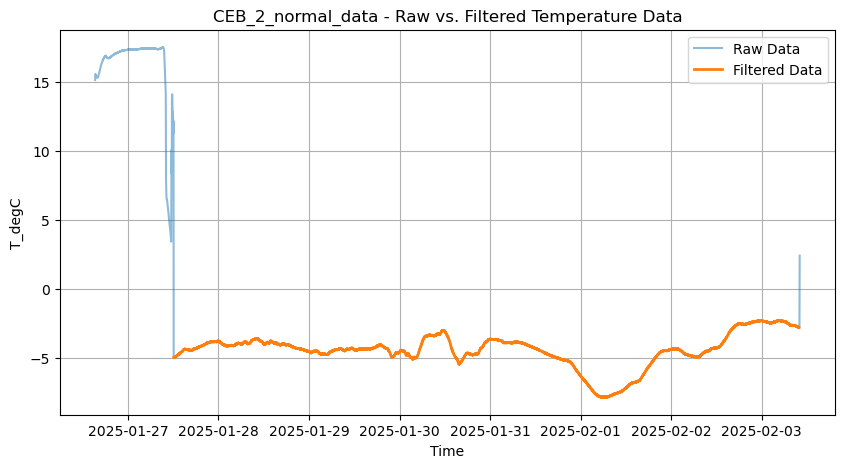

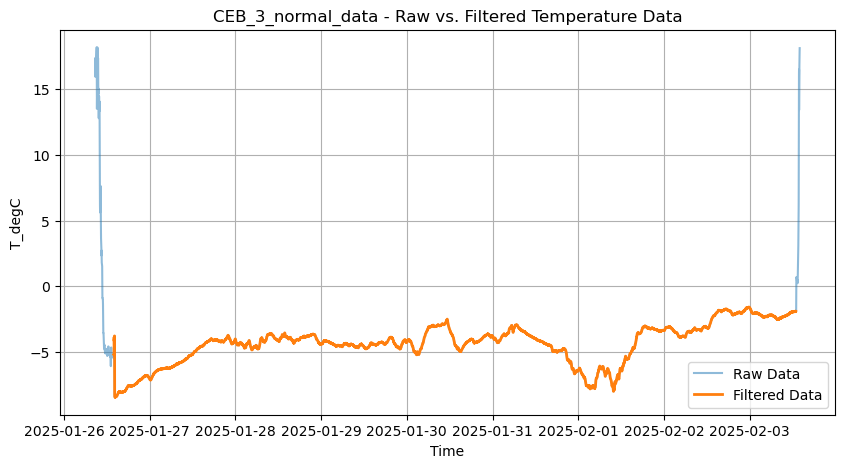

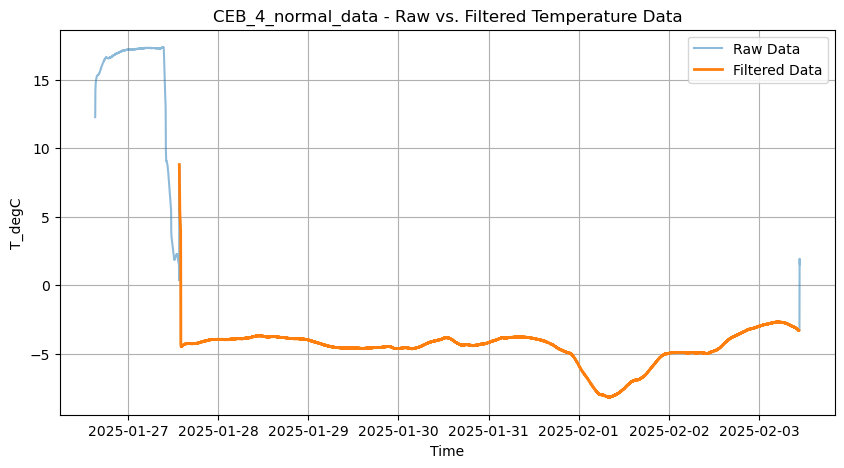

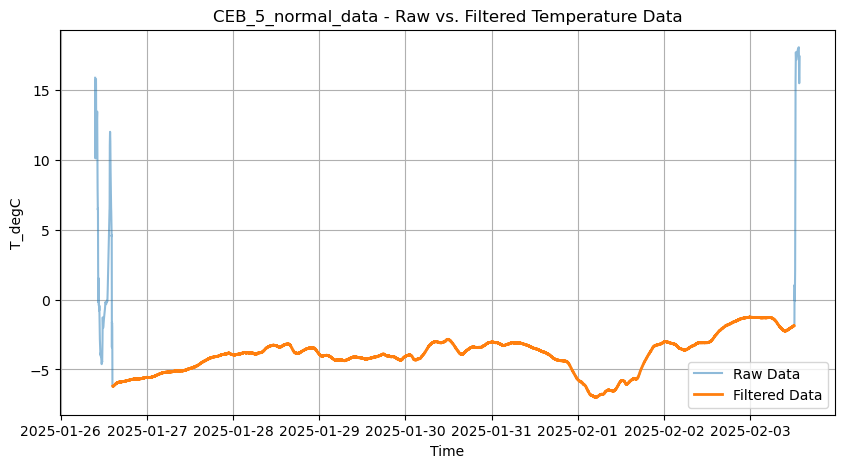

In [33]:
def plot_all_ceb_data(ceb_data, ceb_data_filtered):
    """
    Plots the original and filtered datasets for all TT data.
    
    Parameters:
        TT_data (dict): Dictionary of unfiltered TT datasets.
        TT_data_filtered (dict): Dictionary of filtered TT datasets.
    """
    for key in ceb_data:
        if key in ceb_data_filtered:  # Only plot if there is a filtered version
            plt.figure(figsize=(10, 5))
            plt.plot(ceb_data[key].index, ceb_data[key]['T_degC'], label='Raw Data', alpha=0.5)
            plt.plot(ceb_data_filtered[key].index, ceb_data_filtered[key]['T_degC'], label='Filtered Data', linewidth=2)
            plt.title(f"{key} - Raw vs. Filtered Temperature Data")
            plt.xlabel("Time")
            plt.ylabel("T_degC")
            plt.legend()
            plt.grid(True)
            plt.show()

# Call the function to plot all TT datasets
plot_all_ceb_data(ceb_data, ceb_data_filtered)
